<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cifar_random_initial_weights_decorrelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_validation_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cifar_random_initial_weights_decorrelation

> Purpose of this notebook is to implement our ensemble decorrelation idea

In [ ]:
#| default_exp cifar_random_initial_weights_decorrelation

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [1]:
#| hide
# import os
# from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    from google.colab import drive
    import os
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [ ]:
import os
os.system('pip install .')
os.system('pip install git+https://github.com/hamish-haggerty/base_rbt.git')

0

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *
from cancer_proj.cancer_maintrain_ensemble import *
from self_supervised.augmentations import assert_aug_pipelines
from self_supervised.layers import create_mlp_module

import fastai
test_eq(fastai.__version__,'2.7.11')

import torch
test_eq(torch.__version__,'1.13.1+cu116')


## Load the data

In [4]:
#hps's
device ='cuda' if torch.cuda.is_available() else 'cpu'
cuda = (device=='cuda')
n_in=3
size=32
bs=256 #for training BT
bs_val=256 #for training linear head
bs_test=100 #for evaluating linear head. Divides 10000
ts_val=256 
ts=5120


# Load prior fnames:

In [ ]:
#load
# directory = '/content/drive/My Drive/cifar'
# main_dict = load_dict_from_gdrive(directory=directory,filename='main_dict')

In [ ]:
# fnames = main_dict['fnames']
# fnames_train = main_dict['fnames_train']
# fnames_val = main_dict['fnames_val']

In [5]:
#data: dls, dls_val, dls_test
#get the data: Need dls, dls_val, dls_test
path = untar_data(URLs.CIFAR)
fnames = get_image_files(path / "train")
fnames=fnames.shuffle()

fnames_train = fnames[0:ts]
fnames_val = fnames[ts:]

fnames_test = get_image_files(path / "test")
#fnames_test = fnames[ts+ts_val:ts+ts_val+ts_test]

def label_func(fname):
    return fname.name.split('_')[1].strip('png').strip('.')

#labels for train,eval and test
labels = [label_func(fname) for fname in fnames]
labels_train = labels[0:ts]
labels_val = labels[ts:ts+ts_val]
labels_test = [label_func(fname) for fname in fnames_test]

#Used for training encoder i.e. BT
dls_train = ImageDataLoaders.from_lists(path, fnames_train, labels_train,bs=bs, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)
dls_tune = dls_train

test_eq(ts_val%bs_val,0)
dls_valid = ImageDataLoaders.from_lists(path, fnames_val, labels_val,bs=bs_val, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device,shuffle=False)

#Used for evaluating linear classifier
dls_test = ImageDataLoaders.from_lists(path, fnames_test, labels_test,bs=bs_test, item_tfms=[Resize(size=size)], #batch_tfms=[ToTensor(), IntToFloatTensor()],
                                  valid_pct=0.0,num_workers=12,device=device)

# labels = list(set(labels))
# dls_train.vocab = labels
# dls_tune.vocab = labels
# dls_valid.vocab = labels
# dls_test.vocab = labels




set(labels) #Check that the labels make sense

{'airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck'}

## Load aug pipelines here

In [6]:
#| export

BYOL_Augs = dict(flip_p1=0.5,flip_p2=0.5,jitter_p1=0.8,jitter_p2=0.8,bw_p1=0.2,
                bw_p2=0.2,blur_p1=1.0,blur_p2=0.1,sol_p1=0.0,sol_p2=0.2,noise_p1=0.0,
                noise_p2=0.0,resize_scale=(0.7, 1.0),resize_ratio=(3/4, 4/3),rotate_deg=45.0,
                rotate_p=0.5,blur_r=(0.1,2),blur_s=13,sol_t=0.1,sol_a=0.1,noise_std=0.1
                )


TUNE_Augs=dict(blur_r = BYOL_Augs['blur_r'],blur_s = BYOL_Augs['blur_s'], flip_p=0.25,
                rotate_p=0.25,jitter_p=0.0,bw_p=0.0,blur_p=0.0,resize_scale=(0.7, 1.0),
                resize_ratio=(3/4, 4/3),rotate_deg=45.0
                )

Val_Augs = dict(TUNE_Augs)


def create_aug_pipelines(size,device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs):
    "Create the BT pipelines, the tune and val pipelines"

    aug_dict = {}

    aug_pipelines_1 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p1'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p1'],
                        jitter_p=Augs['jitter_p1'], bw_p=Augs['bw_p1'], blur_p=Augs['blur_p1'],
                        sol_p=Augs['sol_p1'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines_2 = get_barlow_twins_aug_pipelines(size=size,
                        rotate=True,jitter=True,noise=True,bw=True,blur=True,solar=True, #Whether to use aug or not
                        resize_scale=Augs['resize_scale'],resize_ratio=Augs['resize_ratio'],
                        noise_std=Augs['noise_std'], rotate_deg=Augs['rotate_deg'],
                        blur_r=Augs['blur_r'],blur_s=Augs['blur_s'],sol_t=Augs['sol_t'],sol_a=Augs['sol_a'],
                        flip_p=Augs['flip_p2'], rotate_p=Augs['rotate_p'],noise_p=Augs['noise_p2'],
                        jitter_p=Augs['jitter_p2'], bw_p=Augs['bw_p2'], blur_p=Augs['blur_p2'],
                        sol_p=Augs['sol_p2'], #prob of performing aug
                        same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))

    aug_pipelines = [aug_pipelines_1,aug_pipelines_2]


    aug_pipelines_tune =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=TUNE_Augs['resize_scale'],resize_ratio=TUNE_Augs['resize_ratio'],noise_std=None,
                    blur_r=TUNE_Augs['blur_r'],blur_s=TUNE_Augs['blur_s'], rotate_deg=TUNE_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=TUNE_Augs['flip_p'], rotate_p=TUNE_Augs['rotate_p'],noise_p=0.0, jitter_p=TUNE_Augs['jitter_p'],
                    bw_p=TUNE_Augs['bw_p'], blur_p=TUNE_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)




    aug_pipelines_test =  [get_barlow_twins_aug_pipelines(size=size,
                    rotate=True,jitter=True,noise=False,bw=True,blur=True,solar=False, #Whether to use aug or not
                    resize_scale=Val_Augs['resize_scale'],resize_ratio=Val_Augs['resize_ratio'],noise_std=None,
                    blur_r=Val_Augs['blur_r'],blur_s=Val_Augs['blur_s'], rotate_deg=Val_Augs['rotate_deg'],
                    sol_t=None,sol_a=None, #hps of augs
                    flip_p=Val_Augs['flip_p'], rotate_p=Val_Augs['rotate_p'],noise_p=0.0, jitter_p=Val_Augs['jitter_p'],
                    bw_p=Val_Augs['bw_p'], blur_p=Val_Augs['blur_p'],sol_p=0.0, #prob of performing aug
                    same_on_batch=False,stats=Augs['stats'], cuda=(device=='cuda'))]#,P=0.0)

    aug_dict['aug_pipelines'] = aug_pipelines
    aug_dict['aug_pipelines_tune'] = aug_pipelines_tune
    aug_dict['aug_pipelines_test'] = aug_pipelines_test

    return aug_dict



In [7]:
#| hide

_Augs = dict(BYOL_Augs)
_Augs['stats'] = cifar_stats
aug_dict = create_aug_pipelines(size=size,device=device,Augs=_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 1.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.1, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([

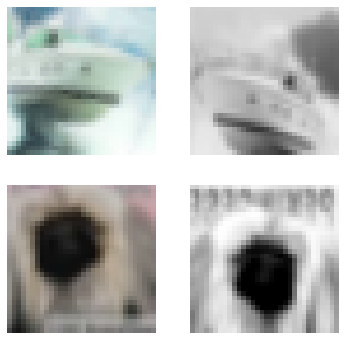

In [ ]:
#| hide
show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]], device='cuda:0'), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]], device='cuda:0'), 'axes': (0, 2, 3)}
Pipeline: 


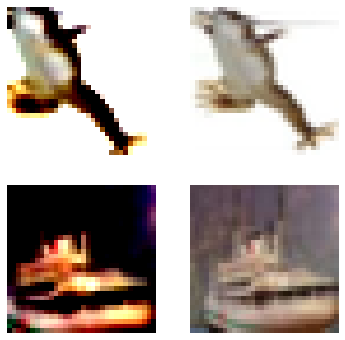

In [ ]:
#| hide

show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [ ]:
#| hide
#show_btens_batch(dls_train,3,aug_pipelines,n=2)

## Step 1) Train two BT models on CIFAR10, and save them

In [23]:
def predict_cifar_model(model,_dls,aug_pipelines_test,numavg=30,criterion = CrossEntropyLossFlat()):
    test_eq(_dls.train.shuffle,False)
    
    total_acc=0
    N = len(_dls.train)
    probs_dict={}
    for i,(xval,yval) in enumerate(_dls.train):

        probs,ypred,acc = predict_model(xval=xval,yval=yval,model=model,
                                        aug_pipelines_test=aug_pipelines_test,
                                        numavg=numavg,
                                        criterion=criterion
                                        )
        

        total_acc += acc
        probs_dict[i]=probs
    
    return total_acc / N, probs_dict


In [11]:
def predict_cifar_ensemble(prob_dict_1,prob_dict_2,_dls):
    test_eq(_dls.train.shuffle,False)

    total_acc=0
    N = len(_dls.train)
    for i,(xval,yval) in enumerate(_dls.train):
        
        probs = 0.5*(prob_dict_1[i]+prob_dict_2[i])

        ypred = cast(torch.argmax(probs, dim=1),TensorCategory)

        correct = (ypred == yval)#.type(torch.FloatTensor)

        #correct = (torch.argmax(ypred,dim=1) == yval).type(torch.FloatTensor)
        num_correct = correct.sum()
        acc = num_correct/xval.shape[0]

        total_acc += acc.item()
    
    return total_acc / N

In [12]:
import os
directory = '/content/drive/My Drive/cifar'
if not os.path.exists(directory):
    os.makedirs(directory)

In [13]:
lmb=0.5*5e-3
lr_max=0.0002754228771664202

In [24]:
xval,yval = dls_valid.train.one_batch()

In [25]:
def run_main_train(pretrain=True,initial_weights='no_pretrain',num_epochs=300,freeze_num_epochs=1,freeze_numfit=6,numfit=75,num=2):
    "run main_train num times."


    main_dict = {}
    for i in range(num):

        tune_model_path = directory + f'/pretrain={pretrain}_{i}.pth'
        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=pretrain,
                num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                print_report=True,
                lmb=lmb,
                lr_max=lr_max,
                tune_model_path = tune_model_path
                        )
        
        #This is so we can re-use the models we train here elsewhere...
        if pretrain==True:
            main.train_encoder()
            bt_model_path = directory+f'/bt_model_{i}'
            torch.save(main.bt_model.state_dict(), bt_model_path) #i.e. bt_model_{0,1,2 etc}
        else:
            bt_model_path=None

        metrics = main.fine_tune()
        
        metrics['bt_model_path'] =  bt_model_path #only interesting under bt pretraining...
        metrics['tune_model_path'] = tune_model_path

        main_dict[i] = metrics

        #can use to debug if needed
        # model = main.model
        # probs,ypred,acc =  predict_model(xval=xval,yval=yval,model=model,aug_pipelines_test=aug_pipelines_test,numavg=30)

        # print(acc)
    return main_dict

In [ ]:
num=3

main_dict = run_main_train(pretrain=True,num_epochs=200,freeze_num_epochs=1,freeze_numfit=6,numfit=50,num=num)
main_dict['fnames']=fnames
main_dict['fnames_train']=fnames_train
main_dict['fnames_val']=fnames_val
save_dict_to_gdrive(d=main_dict,directory=directory,filename='main_dict')

for i in range(num):
    print(main_dict[i]['acc'])

inside patched `fit`


epoch,train_loss,valid_loss,time
0,4451.937988,None,00:05
1,3729.270020,None,00:05
2,3301.683350,None,00:05
3,3062.095215,None,00:05
4,2788.475586,None,00:05
5,2578.360107,None,00:05
6,2390.683350,None,00:05
7,2239.052734,None,00:05
8,2101.145264,None,00:05
9,1982.034912,None,00:05


inside patched `fit`
pretrain was True, and about to use fit


epoch,train_loss,valid_loss,time
0,2.074230,None,00:03
1,1.910553,None,00:03
2,1.841128,None,00:04
3,1.779259,None,00:03
4,1.736268,None,00:03
5,1.700843,None,00:03


epoch,train_loss,valid_loss,time
0,1.710755,None,00:04
1,1.553079,None,00:03
2,1.444948,None,00:03
3,1.364611,None,00:03
4,1.304922,None,00:04
5,1.245593,None,00:03
6,1.187761,None,00:03
7,1.119092,None,00:04
8,1.071611,None,00:03
9,1.038161,None,00:03


inside patched `fit`


epoch,train_loss,valid_loss,time
0,4583.943359,None,00:05
1,3680.195557,None,00:05
2,3264.812500,None,00:05
3,2978.978760,None,00:05
4,2702.690918,None,00:05
5,2423.398193,None,00:05
6,2259.746826,None,00:05
7,2112.794678,None,00:05
8,2004.878418,None,00:05
9,1925.831055,None,00:05


inside patched `fit`
pretrain was True, and about to use fit


epoch,train_loss,valid_loss,time
0,2.015297,None,00:04
1,1.848460,None,00:04
2,1.768172,None,00:05
3,1.712617,None,00:04
4,1.681758,None,00:04
5,1.652184,None,00:04


epoch,train_loss,valid_loss,time
0,1.625122,None,00:05
1,1.492410,None,00:04
2,1.386488,None,00:04
3,1.307961,None,00:04
4,1.250283,None,00:04
5,1.202281,None,00:04
6,1.148089,None,00:04
7,1.080591,None,00:04
8,1.011607,None,00:04
9,0.971189,None,00:04


inside patched `fit`


epoch,train_loss,valid_loss,time
0,4487.271973,None,00:06
1,3597.680420,None,00:06
2,3030.730713,None,00:05
3,2712.062744,None,00:06
4,2464.574707,None,00:06
5,2278.541992,None,00:06
6,2214.895020,None,00:05
7,2172.455566,None,00:06
8,2053.799805,None,00:06
9,2029.030151,None,00:06


inside patched `fit`
pretrain was True, and about to use fit


epoch,train_loss,valid_loss,time
0,1.953814,None,00:03
1,1.829154,None,00:04
2,1.767218,None,00:04
3,1.726033,None,00:04
4,1.693480,None,00:03
5,1.664309,None,00:04


epoch,train_loss,valid_loss,time
0,1.619425,None,00:04
1,1.483682,None,00:04
2,1.406866,None,00:04
3,1.327734,None,00:04
4,1.278792,None,00:04
5,1.221848,None,00:04
6,1.156333,None,00:04
7,1.119368,None,00:04
8,1.074463,None,00:04
9,1.023996,None,00:04


0.5859375
0.67578125
0.62890625


# Ok, now ensemble decorrelation stuff

First load old results from above:

In [ ]:
#save_dict_to_gdrive(d=main_dict,directory=directory,filename='main_dict')

In [15]:
@patch
def before_epoch(self:BarlowTwinsEns):
    "This is explicitly assuming that we train for 300 epochs. Need to patch in otherwise..."
    
    self.t=0.0
    epoch=self.epoch
    s=self.s

    self.rp1 = RandProj()
    self.rp2 = RandProj()

    if epoch < 5:
        s=0.9

    if epoch == 5:
        s=0.5

    if epoch == 25:
        s=0.25

    if epoch == 100:
        s=0.125

    if epoch == 200:
        s=0.05

    if epoch == 290:
        s=0.0

    self.s=s


    return

In [16]:
#| export

def lf_2_proj(pred,I,lmb,
               t,
               s,
               ):
    "Type 2 loss in projector space"

    
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients
    
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)

    #pointwise multiply z^A1 with Z^A2, likewise for B
    z1_3 = z1*z1_2
    z2_3 = z2*z2_2
    z1norm_3 = (z1_3 - z1_3.mean(0)) / (z1_3.std(0, unbiased=False) + 1e-7)
    z2norm_3 = (z2_3 - z2_3.mean(0)) / (z2_3.std(0, unbiased=False) + 1e-7)


    #Make sure gradients are turned off / turned on appropriately
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)

    # #Within frozen model 
    # C = (z1norm.T @ z2norm) / bs 
    # cdiff = (C - I)**2
    
    #Within model_2 (unfrozen)
    C2 = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C2 - I)**2

    #between model for rr
    # C_rr1=(z1norm.T @ z1norm_2) / bs
    # cdiff_rr_1 = C_rr1.pow(2)

    # C_rr2=(z2norm.T @ z2norm_2) / bs
    # cdiff_rr_2 = C_rr2.pow(2)

    # cdiff_rr = 0.5*(cdiff_rr_1 + cdiff_rr_2)

    # t1 = z1norm*z1norm_2 #like z^A1 * Z^A2 ...
    # t2 = z2norm*z2norm_2
    #cdiff_rr = (C_rr.pow(2) + 1e-7).pow(0.5) #keep the units the same

    C_rr = z1norm_3.T @ z2norm_3 / bs

    cdiff_rr = C_rr.pow(2)

    #between model for inv
    C_inva1 = (z1norm.T @ z2norm_2) / bs
    cdiff_inva_1 = (C_inva1-I).pow(2)

    C_inva2 = (z2norm.T @ z1norm_2) / bs
    cdiff_inva_2 = (C_inva2-I).pow(2)

    cdiff_inva = 0.5*(cdiff_inva_1 + cdiff_inva_2)

    # print(f'lmb-scaled between rr is: {lmb*(cdiff_rr*(1-I)).sum()}')
    # print(f'lmb-scaled within rr is: {lmb*(cdiff_2*(1-I)).sum()}')

    # input()
    # assert False

    loss = (1-t)*(cdiff_2*I).sum() + t*(cdiff_inva*I).sum() + (1-s)*lmb*(cdiff_2*(1-I)).sum() + s*lmb*(cdiff_rr*(1-I)).sum()

    torch.cuda.empty_cache()
    return loss


In [17]:
#| export

class RandProj(nn.Module):
    
    def __init__(self,
                 enc_s=2048,
                 proj_s=8192
                ):
        super().__init__()
        
        with torch.no_grad():
            self.m = nn.Sequential(nn.Linear(enc_s,proj_s),nn.Sigmoid(),nn.Linear(proj_s,proj_s)) #feedforward net one hidden layer
        
        for param in self.parameters():
            param.requires_grad = False

        if torch.cuda.is_available(): self.to('cuda')
            
    def forward(self,x):
        return self.m(x)

In [18]:
#| export

    
def lf_3_enc(pred,I,lmb,
               t,
               s,
               rp1=None,
               rp2=None,
               ):
    
    "Standard between model rr except we pass frozen encoder through a random projector"
    pred1 = pred[0] #frozen
    pred2 = pred[1] #has gradients

    pred1_enc = pred[2]
    pred2_enc = pred[3]
    
    
    bs,nf = pred1.size(0)//2,pred1.size(1)

    #All standard, from BT
    z1, z2 = pred1[:bs],pred1[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)
    
    z1_2, z2_2 = pred2[:bs],pred2[bs:] #so z1 is bs*projection_size, likewise for z2
    z1norm_2 = (z1_2 - z1_2.mean(0)) / (z1_2.std(0, unbiased=False) + 1e-7)
    z2norm_2 = (z2_2 - z2_2.mean(0)) / (z2_2.std(0, unbiased=False) + 1e-7)

    z1, z2 = pred1_enc[:bs],pred1_enc[bs:] #so z1 is bs*projection_size, likewise for z2
    
    # rp1 = RandProj()
    # rp2 = RandProj()

    z1,z2 = rp1(z1),rp2(z2)
    
    z1norm_rand = (z1 - z1.mean(0)) / (z1.std(0, unbiased=False) + 1e-7)
    z2norm_rand = (z2 - z2.mean(0)) / (z2.std(0, unbiased=False) + 1e-7)

    #We don't actually need encoder for unfrozen model, I believe, at this point.
    
    #Make sure gradients are turned off / turned on appropriately
    test_eq(pred1.requires_grad,False)
    test_eq(pred2.requires_grad,True)

    # #Within frozen model 
    # C = (z1norm.T @ z2norm) / bs 
    # cdiff = (C - I)**2
    
    #Within model_2 (unfrozen)
    C2 = (z1norm_2.T @ z2norm_2) / bs 
    cdiff_2 = (C2 - I)**2
    
    #between model rr
    C_rr1=(z1norm_rand.T @ z1norm_2) / bs
    cdiff_rr_1 = C_rr1.pow(2)

    C_rr2=(z2norm_rand.T @ z2norm_2) / bs
    cdiff_rr_2 = C_rr2.pow(2)

    cdiff_rr = 0.5*(cdiff_rr_1 + cdiff_rr_2)

    #between model for inv
    C_inva1 = (z1norm.T @ z2norm_2) / bs
    cdiff_inva_1 = (C_inva1+I).pow(2)

    C_inva2 = (z2norm.T @ z1norm_2) / bs
    cdiff_inva_2 = (C_inva2+I).pow(2)

    cdiff_inva = 0.5*(cdiff_inva_1 + cdiff_inva_2)


    loss = (1-t)*(cdiff_2*I).sum() + t*(cdiff_inva*I).sum() + (1-s)*lmb*(cdiff_2*(1-I)).sum() + s*lmb*(cdiff_rr*(1-I)).sum()

    torch.cuda.empty_cache()
    return loss

In [50]:
lf_3_enc

<function __main__.lf_3_enc(pred, I, lmb, t, s, rp1=None, rp2=None)>

In [51]:
import gc

#lf can be: lf_1_enc, lf_1_proj, lf_2_enc, lf_2_proj
def run_main_train_ens(main_dict_1,num_epochs=300,freeze_num_epochs=1,freeze_numfit=6,numfit=75,num=3,_lf=lf_1_enc):

    if _lf == lf_3_enc:

        @patch
        def lf(self:BarlowTwinsEns, pred,*yb): return _lf(pred,I=self.I,lmb=self.lmb,t=self.t,s=self.s,rp1=self.rp1,rp2=self.rp2) #pass them to loss function

    else:

        @patch
        def lf(self:BarlowTwinsEns, pred,*yb): return _lf(pred,I=self.I,lmb=self.lmb,t=self.t,s=self.s) #pass them to loss function



    main_dict_2 = {}
    results = {'net_1':main_dict_1}

    for i in range(num):

        #load 300-epoch model here...
        with torch.no_grad():
            #path = '/content/drive/My Drive/proj_net_1_'+f'{i}'
            path = main_dict_1[i]['bt_model_path'] #300 epoch
            
            bt_model,_ = create_model(which_model='no_pretrain',ps=8192,device=device)
            bt_model.load_state_dict(torch.load(path, map_location='cuda:0'))


        with torch.no_grad():

            main_ens = main_train_ensemble(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                    aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                    initial_weights='no_pretrain',pretrain=True,
                    num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                    print_report=True,model=bt_model,
                    lmb=lmb,
                    lr_max=lr_max,
                    tune_model_path = directory + f'/tune_net_2' + '_' f'{_lf.__name__}' + '_' f'{i}'
                            )
        
        main_ens.train_encoder()
        print('trained second encoder')

        #metrics = main.fine_tune()
        
        print('fine tuned number 1')
        metrics_ens = main_ens.fine_tune()
        print('fine tuned number 2')

        #main_dict_1[i] = metrics
        main_dict_2[i] = metrics_ens

  
    results['net_2'] = main_dict_2

    print(f'{_lf.__name__}'+'_results')

    save_dict_to_gdrive(d=results,directory=directory,filename=f'{_lf.__name__}'+'_results')



In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#run_main_train(main_dict_1,_lf=lf_1_enc
run_main_train_ens(main_dict,_lf=lf_3_enc,num_epochs=200,freeze_num_epochs=1,freeze_numfit=6,numfit=50,num=num)

inside ensemble main and lmb is 0.5*5e-3 as we hoped
inside patched `fit`
about to fit_one_cycle with: 0.0002754228771664202


epoch,train_loss,valid_loss,time
0,8781.214844,None,00:08
1,8776.787109,None,00:08
2,8721.789062,None,00:08
3,8675.170898,None,00:08
4,8637.622070,None,00:08
5,8610.788086,None,00:08
6,8580.715820,None,00:08
7,8556.469727,None,00:08
8,8535.311523,None,00:08
9,8515.911133,None,00:08


trained second encoder
fine tuned number 1
inside patched `fit`
pretrain was True, and about to use fit


epoch,train_loss,valid_loss,time
0,2.024460,None,00:05
1,1.861062,None,00:05
2,1.770298,None,00:05
3,1.705132,None,00:05
4,1.666850,None,00:05
5,1.632794,None,00:05


epoch,train_loss,valid_loss,time
0,2.286381,None,00:05
1,1.942187,None,00:05
2,1.764088,None,00:05
3,1.657642,None,00:05
4,1.574600,None,00:05
5,1.498819,None,00:05
6,1.433946,None,00:05
7,1.404247,None,00:05
8,1.364620,None,00:05
9,1.324078,None,00:05


fine tuned number 2
inside ensemble main and lmb is 0.5*5e-3 as we hoped
inside patched `fit`
about to fit_one_cycle with: 0.0002754228771664202


epoch,train_loss,valid_loss,time
0,8852.022461,None,00:08
1,8783.141602,None,00:08
2,8735.031250,None,00:08
3,8685.854492,None,00:08
4,8662.887695,None,00:08
5,8627.115234,None,00:08
6,8587.976562,None,00:08
7,8552.475586,None,00:08
8,8523.267578,None,00:08
9,8504.915039,None,00:08


#Load results, and display:

In [46]:
from statistics import mean,stdev

def load_results(_lf):
    #_directory = '/content/drive/My Drive/random_initial_weights'
    filename=f'{_lf.__name__}'+'_results'
    results = load_dict_from_gdrive(directory=directory,filename=f'{_lf.__name__}'+'_results')
    main_dict_1 = results['net_1']
    main_dict_2 = results['net_2']
    main_dict_1 = {i:main_dict_1[i] for i in range(num)}
    results = {'net_1':main_dict_1,'net_2':main_dict_2}

    return results,main_dict_1,main_dict_2


from itertools import combinations
def within_ensemble_results(results,key,param='pretrain'):

    print(f'Results for {key}')

    _results = list(results[key].values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    lst=[]
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")

        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        #acc = predict_ensemble(v[0]['probs'],v[1]['probs'],dls_valid)

        print(f'Acc of ensemble is:{acc}\n')
        lst.append(acc)

    print(f"mean is: {mean(lst)}")
    print(f"std is: {stdev(lst)}\n")


import itertools
def between_ensemble_results(results,key1,key2,param='pretrain'):

    _results = list(zip(results[key1].values(), results[key2].values()))
    lst=[]

    for v in _results:

        print(f"\nAcc of first guy in ensemble ({key1}) is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble ({key2}) is: {v[1]['acc']}")
        #acc = predict_cifar_ensemble(v[0]['probs_dict'],v[1]['probs_dict'],dls_valid)
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        lst.append(acc)
        print(f'Acc of ensemble is:{acc}\n')

    print(f"mean is: {mean(lst)}")
    print(f"std is: {stdev(lst)}\n")


# Experiment 0): Train baselines, and also use them in what follows:

In [56]:
num=6
num_epochs=300
freeze_num_epochs=1
freeze_numfit=6
numfit=50

main_dict = run_main_train(pretrain=True,num_epochs=num_epochs,freeze_num_epochs=freeze_num_epochs,
                           freeze_numfit=freeze_numfit,numfit=numfit,num=num
                           )
main_dict['fnames']=fnames
main_dict['fnames_train']=fnames_train
main_dict['fnames_val']=fnames_val
save_dict_to_gdrive(d=main_dict,directory=directory,filename='main_dict')

for i in range(num):
    print(main_dict[i]['acc'])

epoch,train_loss,valid_loss,time
0,8780.867188,None,00:05
1,8764.233398,None,00:06
2,8727.429688,None,00:06
3,8686.476562,None,00:06
4,8643.738281,None,00:05
5,8611.938477,None,00:05
6,8594.524414,None,00:05
7,8569.964844,None,00:05
8,8542.227539,None,00:05
9,8519.180664,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.991649,None,00:03
1,1.798049,None,00:03
2,1.684036,None,00:03
3,1.619262,None,00:03
4,1.568125,None,00:03
5,1.530727,None,00:03


unfroze body


epoch,train_loss,valid_loss,time
0,2.055466,None,00:03
1,1.780386,None,00:03
2,1.613450,None,00:03
3,1.503279,None,00:03
4,1.420700,None,00:03
5,1.357909,None,00:03
6,1.296995,None,00:03
7,1.235243,None,00:03
8,1.181394,None,00:03
9,1.127951,None,00:03


              precision    recall  f1-score   support

    airplane       0.59      0.92      0.72        25
  automobile       0.70      0.35      0.47        20
        bird       0.52      0.48      0.50        27
         cat       0.35      0.48      0.41        25
        deer       0.44      0.53      0.48        15
         dog       0.58      0.54      0.56        28
        frog       0.74      0.57      0.64        30
       horse       0.76      0.53      0.63        30
        ship       0.89      0.74      0.81        34
       truck       0.47      0.68      0.56        22

    accuracy                           0.59       256
   macro avg       0.60      0.58      0.58       256
weighted avg       0.63      0.59      0.59       256



epoch,train_loss,valid_loss,time
0,8900.280273,None,00:05
1,8898.120117,None,00:06
2,8817.452148,None,00:06
3,8761.905273,None,00:06
4,8696.174805,None,00:05
5,8653.474609,None,00:06
6,8612.790039,None,00:06
7,8575.037109,None,00:06
8,8544.446289,None,00:06
9,8510.901367,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.971828,None,00:03
1,1.799775,None,00:03
2,1.683413,None,00:04
3,1.601835,None,00:03
4,1.550158,None,00:03
5,1.512321,None,00:03


unfroze body


epoch,train_loss,valid_loss,time
0,2.071353,None,00:04
1,1.767496,None,00:04
2,1.632835,None,00:04
3,1.517462,None,00:03
4,1.435134,None,00:03
5,1.377217,None,00:04
6,1.325517,None,00:03
7,1.273223,None,00:03
8,1.219125,None,00:04
9,1.151455,None,00:04


              precision    recall  f1-score   support

    airplane       0.75      0.60      0.67        25
  automobile       0.81      0.65      0.72        20
        bird       0.62      0.56      0.59        27
         cat       0.52      0.56      0.54        25
        deer       0.37      0.67      0.48        15
         dog       0.55      0.64      0.59        28
        frog       0.79      0.50      0.61        30
       horse       0.64      0.60      0.62        30
        ship       0.73      0.88      0.80        34
       truck       0.67      0.64      0.65        22

    accuracy                           0.63       256
   macro avg       0.65      0.63      0.63       256
weighted avg       0.66      0.63      0.64       256



epoch,train_loss,valid_loss,time
0,8862.521484,None,00:05
1,8779.014648,None,00:05
2,8724.483398,None,00:05
3,8684.419922,None,00:06
4,8648.559570,None,00:05
5,8615.473633,None,00:05
6,8590.689453,None,00:05
7,8567.164062,None,00:05
8,8539.929688,None,00:06
9,8520.818359,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.967349,None,00:03
1,1.778539,None,00:04
2,1.676609,None,00:04
3,1.602210,None,00:04
4,1.557528,None,00:04
5,1.526299,None,00:04


unfroze body


epoch,train_loss,valid_loss,time
0,2.087854,None,00:04
1,1.797803,None,00:04
2,1.631571,None,00:05
3,1.520614,None,00:04
4,1.425725,None,00:04
5,1.353563,None,00:04
6,1.295176,None,00:04
7,1.234450,None,00:04
8,1.189902,None,00:04
9,1.146222,None,00:04


              precision    recall  f1-score   support

    airplane       0.71      0.68      0.69        25
  automobile       0.58      0.55      0.56        20
        bird       0.49      0.63      0.55        27
         cat       0.64      0.28      0.39        25
        deer       0.37      0.47      0.41        15
         dog       0.53      0.61      0.57        28
        frog       0.60      0.50      0.55        30
       horse       0.77      0.67      0.71        30
        ship       0.65      0.88      0.75        34
       truck       0.63      0.55      0.59        22

    accuracy                           0.60       256
   macro avg       0.60      0.58      0.58       256
weighted avg       0.61      0.60      0.59       256



epoch,train_loss,valid_loss,time
0,8809.043945,None,00:06
1,8755.895508,None,00:07
2,8723.419922,None,00:06
3,8697.583008,None,00:06
4,8664.095703,None,00:06
5,8637.250977,None,00:06
6,8612.000000,None,00:06
7,8584.939453,None,00:06
8,8560.835938,None,00:06
9,8536.995117,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.914233,None,00:05
1,1.726540,None,00:04
2,1.646535,None,00:05
3,1.592006,None,00:05
4,1.546802,None,00:04
5,1.517061,None,00:04


unfroze body


epoch,train_loss,valid_loss,time
0,2.163821,None,00:04
1,1.863837,None,00:05
2,1.687200,None,00:05
3,1.581939,None,00:04
4,1.490956,None,00:04
5,1.404048,None,00:05
6,1.315564,None,00:05
7,1.259932,None,00:04
8,1.212128,None,00:04
9,1.132803,None,00:05


              precision    recall  f1-score   support

    airplane       0.94      0.68      0.79        25
  automobile       0.65      0.65      0.65        20
        bird       0.55      0.44      0.49        27
         cat       0.32      0.28      0.30        25
        deer       0.39      0.47      0.42        15
         dog       0.66      0.68      0.67        28
        frog       0.55      0.73      0.63        30
       horse       0.69      0.60      0.64        30
        ship       0.82      0.82      0.82        34
       truck       0.59      0.73      0.65        22

    accuracy                           0.62       256
   macro avg       0.62      0.61      0.61       256
weighted avg       0.63      0.62      0.62       256



epoch,train_loss,valid_loss,time
0,8827.429688,None,00:06
1,8798.211914,None,00:06
2,8787.530273,None,00:06
3,8743.251953,None,00:06
4,8717.500000,None,00:06
5,8671.430664,None,00:06
6,8639.441406,None,00:06
7,8606.569336,None,00:06
8,8575.753906,None,00:06
9,8546.388672,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.975417,None,00:04
1,1.747533,None,00:04
2,1.638125,None,00:04
3,1.576729,None,00:04
4,1.528474,None,00:04
5,1.509184,None,00:04


unfroze body


epoch,train_loss,valid_loss,time
0,2.121967,None,00:04
1,1.852734,None,00:04
2,1.695002,None,00:04
3,1.573785,None,00:04
4,1.474831,None,00:04
5,1.402632,None,00:04
6,1.308937,None,00:04
7,1.238007,None,00:04
8,1.188056,None,00:04
9,1.135661,None,00:04


              precision    recall  f1-score   support

    airplane       0.61      0.76      0.68        25
  automobile       0.82      0.70      0.76        20
        bird       0.48      0.56      0.52        27
         cat       0.46      0.44      0.45        25
        deer       0.42      0.33      0.37        15
         dog       0.57      0.75      0.65        28
        frog       0.65      0.57      0.61        30
       horse       0.56      0.60      0.58        30
        ship       0.90      0.79      0.84        34
       truck       0.75      0.55      0.63        22

    accuracy                           0.62       256
   macro avg       0.62      0.60      0.61       256
weighted avg       0.63      0.62      0.62       256



epoch,train_loss,valid_loss,time
0,8870.777344,None,00:06
1,8783.843750,None,00:06
2,8747.545898,None,00:06
3,8692.452148,None,00:06
4,8678.974609,None,00:06
5,8643.086914,None,00:06
6,8602.481445,None,00:06
7,8573.024414,None,00:06
8,8546.993164,None,00:06
9,8527.503906,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


froze body


epoch,train_loss,valid_loss,time
0,1.977982,None,00:04
1,1.785886,None,00:04
2,1.673856,None,00:05
3,1.617571,None,00:04
4,1.565809,None,00:04
5,1.524269,None,00:04


unfroze body


epoch,train_loss,valid_loss,time
0,2.038148,None,00:04
1,1.765326,None,00:04
2,1.603850,None,00:04
3,1.512169,None,00:04
4,1.417377,None,00:04
5,1.334091,None,00:05
6,1.265587,None,00:04
7,1.211320,None,00:05
8,1.157873,None,00:05
9,1.106037,None,00:04


              precision    recall  f1-score   support

    airplane       0.75      0.72      0.73        25
  automobile       0.57      0.85      0.68        20
        bird       0.56      0.52      0.54        27
         cat       0.42      0.52      0.46        25
        deer       0.38      0.53      0.44        15
         dog       0.57      0.71      0.63        28
        frog       0.91      0.33      0.49        30
       horse       0.64      0.53      0.58        30
        ship       0.86      0.88      0.87        34
       truck       0.68      0.59      0.63        22

    accuracy                           0.62       256
   macro avg       0.63      0.62      0.61       256
weighted avg       0.66      0.62      0.62       256

0.58984375
0.6328125
0.59765625
0.62109375
0.62109375
0.62109375


#Experiments:

In [57]:
#run experiment

def run_experiment(_lf,main_dict,num_epochs,freeze_num_epochs,
                            freeze_numfit,numfit,num):

    #run experiment
    run_main_train_ens(main_dict,_lf=_lf,num_epochs=num_epochs,freeze_num_epochs=freeze_num_epochs,
                            freeze_numfit=freeze_numfit,numfit=numfit,num=num
                            )
    #get results and print

    print(f'results for _lf={_lf.__name__}')
    results,main_dict_1,main_dict_2 =  load_results(_lf=_lf)
    
    print('First nets trained have acc: ')
    lst_1 = [main_dict_1[i]['acc'] for i in range(num)]
    print(lst_1)
    print(f'And the mean for first nets is: {mean(lst_1)}')

    print('Second nets trained have acc: ')
    lst_2 = [main_dict_2[i]['acc'] for i in range(num)]
    print(lst_2)
    print(f'And the mean for second nets is: {mean(lst_2)}')

    print('within ensemble results for net_1:')
    within_ensemble_results(results,key='net_1',param='pretrain')
    print('within ensemble results for net_2:')
    within_ensemble_results(results,key='net_2',param='pretrain')
    print('between ensemble results:')
    between_ensemble_results(results,key1='net_1',key2='net_2',param='pretrain')



In [59]:
run_experiment(_lf=lf_3_enc,main_dict=main_dict,num_epochs=num_epochs,freeze_num_epochs=freeze_num_epochs,
                        freeze_numfit=freeze_numfit,numfit=numfit,num=num)

epoch,train_loss,valid_loss,time
0,8227.041992,None,00:10
1,8094.978027,None,00:11
2,7868.009766,None,00:09
3,7721.838379,None,00:11
4,7626.097168,None,00:11
5,8596.821289,None,00:11
6,8966.781250,None,00:10
7,8840.504883,None,00:11
8,8747.475586,None,00:11
9,8673.851562,None,00:09


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.960170,None,00:06
1,1.777593,None,00:06
2,1.698080,None,00:06
3,1.643406,None,00:06
4,1.589733,None,00:06
5,1.555380,None,00:06


unfroze body


epoch,train_loss,valid_loss,time
0,2.013414,None,00:06
1,1.771465,None,00:06
2,1.629260,None,00:06
3,1.523293,None,00:06
4,1.438054,None,00:06
5,1.372835,None,00:06
6,1.309450,None,00:06
7,1.278884,None,00:06
8,1.203673,None,00:06
9,1.134317,None,00:06


              precision    recall  f1-score   support

    airplane       0.83      0.60      0.70        25
  automobile       0.80      0.60      0.69        20
        bird       0.56      0.52      0.54        27
         cat       0.40      0.56      0.47        25
        deer       0.38      0.40      0.39        15
         dog       0.53      0.75      0.62        28
        frog       0.71      0.57      0.63        30
       horse       0.78      0.47      0.58        30
        ship       0.75      0.88      0.81        34
       truck       0.56      0.64      0.60        22

    accuracy                           0.61       256
   macro avg       0.63      0.60      0.60       256
weighted avg       0.64      0.61      0.62       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8259.037109,None,00:09
1,8082.572266,None,00:09
2,7784.501465,None,00:09
3,7706.751953,None,00:10
4,7649.881836,None,00:10
5,8674.554688,None,00:09
6,8871.068359,None,00:10
7,8763.781250,None,00:10
8,8706.904297,None,00:09
9,8654.034180,None,00:09


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.065695,None,00:08
1,1.853993,None,00:08
2,1.765239,None,00:09
3,1.696711,None,00:06
4,1.651546,None,00:08
5,1.616016,None,00:08


unfroze body


epoch,train_loss,valid_loss,time
0,2.085878,None,00:08
1,1.821371,None,00:07
2,1.694041,None,00:08
3,1.581488,None,00:08
4,1.491791,None,00:09
5,1.410100,None,00:06
6,1.337665,None,00:08
7,1.273245,None,00:08
8,1.219380,None,00:09
9,1.194602,None,00:08


              precision    recall  f1-score   support

    airplane       0.69      0.88      0.77        25
  automobile       0.76      0.65      0.70        20
        bird       0.55      0.41      0.47        27
         cat       0.43      0.48      0.45        25
        deer       0.26      0.40      0.32        15
         dog       0.47      0.64      0.55        28
        frog       0.67      0.60      0.63        30
       horse       0.65      0.57      0.61        30
        ship       0.96      0.68      0.79        34
       truck       0.71      0.68      0.70        22

    accuracy                           0.61       256
   macro avg       0.62      0.60      0.60       256
weighted avg       0.64      0.61      0.61       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8325.753906,None,00:12
1,8062.516602,None,00:11
2,7809.209961,None,00:12
3,7669.062500,None,00:12
4,7615.127930,None,00:11
5,8952.146484,None,00:12
6,9002.930664,None,00:12
7,8881.503906,None,00:10
8,8799.413086,None,00:11
9,8713.816406,None,00:12


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.050267,None,00:07
1,1.851542,None,00:07
2,1.738922,None,00:07
3,1.673697,None,00:07
4,1.639768,None,00:07
5,1.604591,None,00:07


unfroze body


epoch,train_loss,valid_loss,time
0,2.064137,None,00:07
1,1.789711,None,00:07
2,1.638461,None,00:07
3,1.528677,None,00:07
4,1.456959,None,00:07
5,1.386453,None,00:07
6,1.331459,None,00:07
7,1.269578,None,00:07
8,1.205495,None,00:07
9,1.164685,None,00:07


              precision    recall  f1-score   support

    airplane       0.69      0.72      0.71        25
  automobile       0.55      0.55      0.55        20
        bird       0.70      0.52      0.60        27
         cat       0.39      0.44      0.42        25
        deer       0.28      0.53      0.36        15
         dog       0.56      0.64      0.60        28
        frog       0.55      0.53      0.54        30
       horse       0.63      0.40      0.49        30
        ship       0.67      0.76      0.71        34
       truck       0.57      0.36      0.44        22

    accuracy                           0.55       256
   macro avg       0.56      0.55      0.54       256
weighted avg       0.58      0.55      0.56       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8296.827148,None,00:10
1,8082.880371,None,00:10
2,7825.465332,None,00:10
3,7675.414062,None,00:10
4,7587.102539,None,00:10
5,8811.382812,None,00:10
6,9122.602539,None,00:10
7,8953.945312,None,00:10
8,8826.074219,None,00:10
9,8726.025391,None,00:10


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.116833,None,00:09
1,1.933293,None,00:08
2,1.839181,None,00:09
3,1.788600,None,00:10
4,1.757984,None,00:09
5,1.736496,None,00:09


unfroze body


epoch,train_loss,valid_loss,time
0,2.101780,None,00:09
1,1.833891,None,00:09
2,1.685357,None,00:09
3,1.595950,None,00:08
4,1.514360,None,00:09
5,1.443063,None,00:09
6,1.382705,None,00:09
7,1.330940,None,00:09
8,1.306099,None,00:09
9,1.254926,None,00:10


              precision    recall  f1-score   support

    airplane       0.60      0.72      0.65        25
  automobile       0.75      0.60      0.67        20
        bird       0.47      0.59      0.52        27
         cat       0.44      0.44      0.44        25
        deer       0.28      0.33      0.30        15
         dog       0.54      0.54      0.54        28
        frog       0.68      0.57      0.62        30
       horse       0.59      0.63      0.61        30
        ship       0.85      0.85      0.85        34
       truck       0.79      0.50      0.61        22

    accuracy                           0.60       256
   macro avg       0.60      0.58      0.58       256
weighted avg       0.61      0.60      0.60       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8244.567383,None,00:12
1,8075.063477,None,00:10
2,7823.353027,None,00:12
3,7718.507812,None,00:13
4,7604.119629,None,00:12
5,8527.100586,None,00:12
6,8642.286133,None,00:12
7,8706.271484,None,00:13
8,8717.371094,None,00:10
9,8660.477539,None,00:12


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.955721,None,00:07
1,1.785627,None,00:08
2,1.699903,None,00:07
3,1.645088,None,00:07
4,1.614256,None,00:07
5,1.582611,None,00:08


unfroze body


epoch,train_loss,valid_loss,time
0,2.041710,None,00:07
1,1.779252,None,00:08
2,1.638661,None,00:08
3,1.529085,None,00:08
4,1.451620,None,00:07
5,1.385712,None,00:08
6,1.343396,None,00:08
7,1.292025,None,00:08
8,1.228700,None,00:08
9,1.178182,None,00:08


              precision    recall  f1-score   support

    airplane       0.66      0.84      0.74        25
  automobile       0.82      0.45      0.58        20
        bird       0.75      0.33      0.46        27
         cat       0.78      0.28      0.41        25
        deer       0.38      0.60      0.46        15
         dog       0.59      0.79      0.68        28
        frog       0.45      0.83      0.58        30
       horse       0.88      0.50      0.64        30
        ship       0.83      0.74      0.78        34
       truck       0.57      0.73      0.64        22

    accuracy                           0.62       256
   macro avg       0.67      0.61      0.60       256
weighted avg       0.69      0.62      0.61       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8333.270508,None,00:10
1,8070.047852,None,00:11
2,7802.286621,None,00:11
3,7628.864258,None,00:11
4,7538.341309,None,00:11
5,8842.874023,None,00:11
6,8932.969727,None,00:11
7,8900.928711,None,00:11
8,8804.878906,None,00:11
9,8705.672852,None,00:11


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.997369,None,00:10
1,1.823264,None,00:09
2,1.728862,None,00:10
3,1.678931,None,00:11
4,1.638721,None,00:08
5,1.601812,None,00:10


unfroze body


epoch,train_loss,valid_loss,time
0,2.008085,None,00:10
1,1.752321,None,00:11
2,1.616395,None,00:08
3,1.526002,None,00:10
4,1.436560,None,00:10
5,1.381807,None,00:10
6,1.331329,None,00:08
7,1.299169,None,00:10
8,1.254153,None,00:10
9,1.204493,None,00:11


epoch,train_loss,valid_loss,time
0,2.008085,None,00:10
1,1.752321,None,00:11
2,1.616395,None,00:08
3,1.526002,None,00:10
4,1.436560,None,00:10
5,1.381807,None,00:10
6,1.331329,None,00:08
7,1.299169,None,00:10
8,1.254153,None,00:10
9,1.204493,None,00:11


              precision    recall  f1-score   support

    airplane       0.75      0.72      0.73        25
  automobile       0.68      0.65      0.67        20
        bird       0.67      0.44      0.53        27
         cat       0.43      0.64      0.52        25
        deer       0.38      0.53      0.44        15
         dog       0.64      0.57      0.60        28
        frog       0.61      0.57      0.59        30
       horse       0.70      0.53      0.60        30
        ship       0.75      0.79      0.77        34
       truck       0.68      0.77      0.72        22

    accuracy                           0.62       256
   macro avg       0.63      0.62      0.62       256
weighted avg       0.64      0.62      0.63       256

fine tuned number 2
lf_3_enc_results
results for _lf=lf_3_enc
First nets trained have acc: 
[0.58984375, 0.6328125, 0.59765625, 0.62109375, 0.62109375, 0.62109375]
And the mean for first nets is: 0.6139322916666666
Second nets trained have a

In [ ]:
mean is: 0.6518229166666667
std is: 0.02420914748190434

In [58]:
run_experiment(_lf=lf_2_proj,main_dict=main_dict,num_epochs=num_epochs,freeze_num_epochs=freeze_num_epochs,
                        freeze_numfit=freeze_numfit,numfit=numfit,num=num)

epoch,train_loss,valid_loss,time
0,8502.395508,None,00:08
1,8274.424805,None,00:07
2,8023.178711,None,00:08
3,7744.887695,None,00:07
4,7391.270020,None,00:08
5,8107.825195,None,00:08
6,8181.622070,None,00:07
7,8208.404297,None,00:07
8,8205.398438,None,00:07
9,8197.550781,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.908031,None,00:05
1,1.735232,None,00:05
2,1.665483,None,00:06
3,1.596552,None,00:06
4,1.544691,None,00:05
5,1.508445,None,00:06


unfroze body


epoch,train_loss,valid_loss,time
0,2.020536,None,00:06
1,1.771890,None,00:07
2,1.616176,None,00:05
3,1.503985,None,00:05
4,1.415203,None,00:05
5,1.325038,None,00:05
6,1.255185,None,00:05
7,1.217250,None,00:05
8,1.155363,None,00:05
9,1.112372,None,00:05


              precision    recall  f1-score   support

    airplane       0.54      0.76      0.63        25
  automobile       0.57      0.80      0.67        20
        bird       0.56      0.74      0.63        27
         cat       0.47      0.36      0.41        25
        deer       0.37      0.47      0.41        15
         dog       0.83      0.36      0.50        28
        frog       0.88      0.50      0.64        30
       horse       0.91      0.67      0.77        30
        ship       0.67      0.94      0.78        34
       truck       0.60      0.55      0.57        22

    accuracy                           0.62       256
   macro avg       0.64      0.61      0.60       256
weighted avg       0.67      0.62      0.62       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8408.469727,None,00:08
1,8145.600586,None,00:08
2,7843.195312,None,00:08
3,7537.921387,None,00:08
4,7213.145508,None,00:08
5,8409.126953,None,00:08
6,8386.363281,None,00:08
7,8365.125977,None,00:08
8,8319.234375,None,00:08
9,8276.166992,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.915815,None,00:06
1,1.717330,None,00:06
2,1.625915,None,00:06
3,1.566187,None,00:05
4,1.517090,None,00:06
5,1.492174,None,00:06


unfroze body


epoch,train_loss,valid_loss,time
0,1.986335,None,00:06
1,1.744693,None,00:06
2,1.598935,None,00:06
3,1.496580,None,00:06
4,1.399373,None,00:06
5,1.324930,None,00:05
6,1.270762,None,00:06
7,1.212061,None,00:06
8,1.167232,None,00:06
9,1.112047,None,00:05


              precision    recall  f1-score   support

    airplane       0.80      0.80      0.80        25
  automobile       0.65      0.65      0.65        20
        bird       0.56      0.37      0.44        27
         cat       0.58      0.28      0.38        25
        deer       0.47      0.53      0.50        15
         dog       0.49      0.89      0.63        28
        frog       0.59      0.63      0.61        30
       horse       0.70      0.53      0.60        30
        ship       0.74      0.82      0.78        34
       truck       0.60      0.55      0.57        22

    accuracy                           0.62       256
   macro avg       0.62      0.61      0.60       256
weighted avg       0.63      0.62      0.61       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8434.242188,None,00:09
1,8153.024902,None,00:09
2,7919.230469,None,00:09
3,7653.272949,None,00:08
4,7328.639160,None,00:09
5,8211.411133,None,00:09
6,8253.916016,None,00:09
7,8289.426758,None,00:09
8,8273.293945,None,00:09
9,8240.274414,None,00:10


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,1.883602,None,00:06
1,1.714892,None,00:06
2,1.637400,None,00:06
3,1.575280,None,00:05
4,1.541301,None,00:06
5,1.500086,None,00:06


unfroze body


epoch,train_loss,valid_loss,time
0,2.018289,None,00:07
1,1.771417,None,00:05
2,1.600279,None,00:06
3,1.487547,None,00:06
4,1.386949,None,00:06
5,1.318940,None,00:06
6,1.248310,None,00:05
7,1.215099,None,00:06
8,1.157259,None,00:07
9,1.104842,None,00:06


              precision    recall  f1-score   support

    airplane       0.76      0.76      0.76        25
  automobile       0.67      0.50      0.57        20
        bird       0.48      0.74      0.58        27
         cat       0.57      0.48      0.52        25
        deer       0.54      0.47      0.50        15
         dog       0.64      0.57      0.60        28
        frog       0.75      0.60      0.67        30
       horse       0.56      0.67      0.61        30
        ship       0.80      0.82      0.81        34
       truck       0.60      0.55      0.57        22

    accuracy                           0.63       256
   macro avg       0.64      0.62      0.62       256
weighted avg       0.64      0.63      0.63       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8591.636719,None,00:09
1,8395.050781,None,00:09
2,8133.914062,None,00:10
3,7930.396973,None,00:10
4,7550.609863,None,00:09
5,8237.257812,None,00:09
6,8276.641602,None,00:10
7,8310.422852,None,00:08
8,8279.043945,None,00:09
9,8262.635742,None,00:10


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.001359,None,00:05
1,1.792848,None,00:05
2,1.699535,None,00:05
3,1.630740,None,00:05
4,1.583193,None,00:05
5,1.540074,None,00:05


unfroze body


epoch,train_loss,valid_loss,time
0,2.100171,None,00:05
1,1.804244,None,00:05
2,1.641859,None,00:05
3,1.518946,None,00:05
4,1.415499,None,00:05
5,1.346765,None,00:06
6,1.294782,None,00:06
7,1.241197,None,00:05
8,1.190763,None,00:05
9,1.131322,None,00:05


              precision    recall  f1-score   support

    airplane       0.69      0.72      0.71        25
  automobile       0.65      0.55      0.59        20
        bird       0.75      0.33      0.46        27
         cat       0.42      0.40      0.41        25
        deer       0.39      0.60      0.47        15
         dog       0.56      0.71      0.63        28
        frog       0.72      0.43      0.54        30
       horse       0.47      0.73      0.57        30
        ship       0.90      0.79      0.84        34
       truck       0.70      0.73      0.71        22

    accuracy                           0.61       256
   macro avg       0.62      0.60      0.59       256
weighted avg       0.64      0.61      0.60       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8566.291992,None,00:09
1,8330.513672,None,00:08
2,8048.533203,None,00:08
3,7739.081543,None,00:08
4,7450.527344,None,00:08
5,8266.089844,None,00:08
6,8269.846680,None,00:08
7,8281.405273,None,00:08
8,8250.937500,None,00:08
9,8232.599609,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.028246,None,00:07
1,1.794137,None,00:05
2,1.668746,None,00:07
3,1.594465,None,00:07
4,1.555361,None,00:08
5,1.513350,None,00:05


unfroze body


epoch,train_loss,valid_loss,time
0,2.029589,None,00:06
1,1.777269,None,00:06
2,1.627744,None,00:06
3,1.506113,None,00:06
4,1.421740,None,00:06
5,1.343308,None,00:06
6,1.291613,None,00:06
7,1.255413,None,00:06
8,1.208585,None,00:06
9,1.173447,None,00:06


              precision    recall  f1-score   support

    airplane       0.75      0.72      0.73        25
  automobile       0.60      0.45      0.51        20
        bird       0.52      0.44      0.48        27
         cat       0.39      0.36      0.37        25
        deer       0.43      0.67      0.53        15
         dog       0.49      0.68      0.57        28
        frog       0.69      0.60      0.64        30
       horse       0.62      0.60      0.61        30
        ship       0.84      0.79      0.82        34
       truck       0.55      0.55      0.55        22

    accuracy                           0.59       256
   macro avg       0.59      0.59      0.58       256
weighted avg       0.60      0.59      0.59       256

fine tuned number 2


epoch,train_loss,valid_loss,time
0,8502.522461,None,00:09
1,8231.390625,None,00:09
2,8062.261719,None,00:09
3,7710.426270,None,00:09
4,7375.587402,None,00:09
5,8248.255859,None,00:09
6,8292.801758,None,00:09
7,8300.994141,None,00:09
8,8283.282227,None,00:09
9,8269.987305,None,00:09


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


trained second encoder
fine tuned number 1
froze body


epoch,train_loss,valid_loss,time
0,2.012542,None,00:06
1,1.797188,None,00:07
2,1.689369,None,00:07
3,1.626917,None,00:07
4,1.585793,None,00:06
5,1.549847,None,00:07


unfroze body


epoch,train_loss,valid_loss,time
0,2.114556,None,00:08
1,1.793224,None,00:08
2,1.644193,None,00:06
3,1.529843,None,00:07
4,1.455842,None,00:08
5,1.412975,None,00:08
6,1.338149,None,00:06
7,1.269719,None,00:08
8,1.208856,None,00:08
9,1.165647,None,00:08


epoch,train_loss,valid_loss,time
0,2.114556,None,00:08
1,1.793224,None,00:08
2,1.644193,None,00:06
3,1.529843,None,00:07
4,1.455842,None,00:08
5,1.412975,None,00:08
6,1.338149,None,00:06
7,1.269719,None,00:08
8,1.208856,None,00:08
9,1.165647,None,00:08


              precision    recall  f1-score   support

    airplane       0.67      0.80      0.73        25
  automobile       0.65      0.55      0.59        20
        bird       0.56      0.52      0.54        27
         cat       0.42      0.56      0.48        25
        deer       0.50      0.47      0.48        15
         dog       0.61      0.61      0.61        28
        frog       0.67      0.67      0.67        30
       horse       0.68      0.63      0.66        30
        ship       0.87      0.79      0.83        34
       truck       0.60      0.55      0.57        22

    accuracy                           0.63       256
   macro avg       0.62      0.61      0.62       256
weighted avg       0.64      0.63      0.63       256

fine tuned number 2
lf_2_proj_results
results for _lf=lf_2_proj
First nets trained have acc: 
[0.58984375, 0.6328125, 0.59765625, 0.62109375, 0.62109375, 0.62109375]
And the mean for first nets is: 0.6139322916666666
Second nets trained have